In [1]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import scipy.sparse as sps
import random
import os
#from pymnet import *

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

#function to create list of n_iter combination of nonco virus indexes with a fixed random seed for repitibility
def SamplingForNoco(n_iter, start=0, group_dim=8, random_seed=1234):
    np.random.seed(random_seed)
    nonco_cond = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))
    
    nonco_sampling = np.array([np.random.choice(nonco_cond[0], group_dim, replace=False) for i in range(n_iter+start)])
    return nonco_sampling[start:(n_iter+start)]

## Statistics

In [2]:
o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o_lcc.txt")
o_lic = np.loadtxt("../Data/ComponentsNew/LIC/o_lic.txt")
o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o_lvc.txt")

n_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n_lcc.txt")
n_lic = np.loadtxt("../Data/ComponentsNew/LIC/n_lic.txt")
n_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n_lvc.txt")

n1o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o_lcc.txt")
n1o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o_lic.txt")
n1o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o_lvc.txt")

n2o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o_lcc.txt")
n2o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o_lic.txt")
n2o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o_lvc.txt")

n3o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n3o_lcc.txt")
n3o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n3o_lic.txt")
n3o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n3o_lvc.txt")

n1o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o1s_lcc.txt")
n1o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o1s_lic.txt")
n1o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o1s_lvc.txt")

n2o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o1s_lcc.txt")
n2o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o1s_lic.txt")
n2o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o1s_lvc.txt")

n1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1s_lcc.txt")
n1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1s_lic.txt")
n1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1s_lvc.txt")

o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o1s_lcc.txt")
o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/o1s_lic.txt")
o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o1s_lvc.txt")

In [4]:
from matplotlib import cm

In [17]:
n_lic

array([ 1., 58.,  7., ..., 47.,  8.,  0.])

(0.0, 0.004)

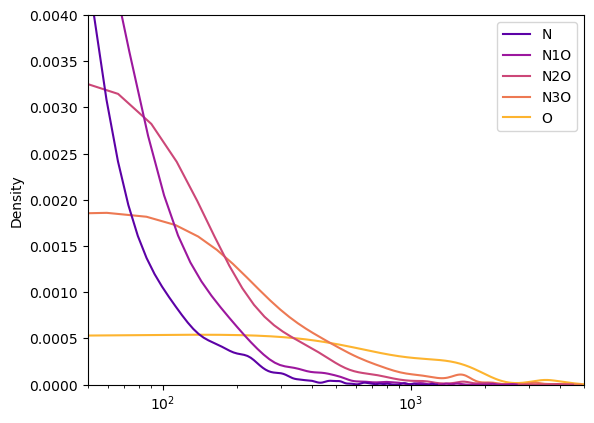

In [24]:
sns.kdeplot(dict({"N": n_lic+1, "N1O": n1o_lic+1, "N2O": n2o_lic+1,"N3O": n3o_lic+1,"O": o_lic+1}), 
            palette="plasma", common_norm=False)#hue=[cmap(i) for i in [0,0.2,0.4,0.6,0.8]])
plt.xscale("log")
plt.xlim([50,5000])
plt.ylim([0,0.004])

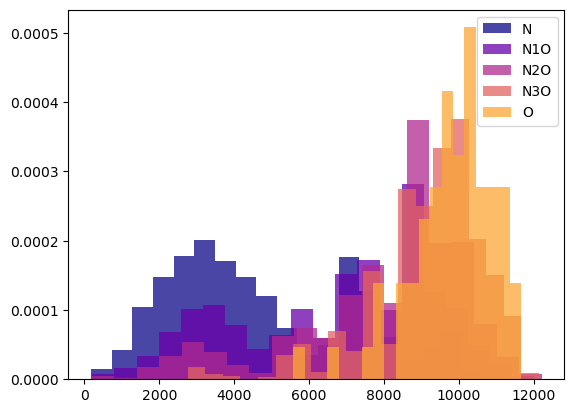

In [199]:
cmap = cm.get_cmap("plasma")

plt.hist(n_lcc, density=True, bins=20, alpha=0.75, color=cmap(0), label="N")
plt.hist(n1o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.2), label="N1O")
plt.hist(n2o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.4), label="N2O")
plt.hist(n3o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.6), label="N3O")
plt.hist(o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.8), label="O")

plt.legend()

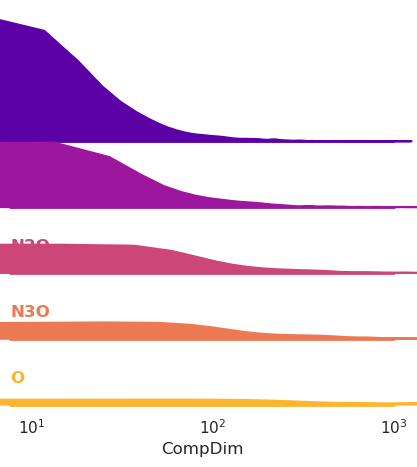

In [341]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(n_lic),
                    ["N1O"]*len(n1o_lic),
                    ["N2O"]*len(n2o_lic),
                    ["N3O"]*len(n3o_lic),
                    ["O"]*len(o_lic)])
                   
x = np.concatenate([n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic])+1
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xscale="log", xlim=[0,1000])
g.despine(bottom=True, left=True)

In [334]:
x

array([ 1., 58.,  7., ..., 41., 32., 33.])

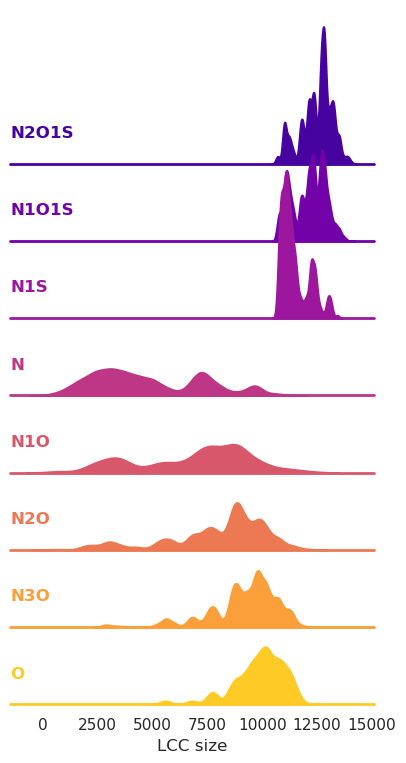

In [28]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N2O1S"]*len(n2o1s_lcc),
                    ["N1O1S"]*len(n1o1s_lcc),
                    ["N1S"]*len(n1s_lcc),
                    ["N"]*len(n_lcc),
                   ["N1O"]*len(n1o_lcc),
                   ["N2O"]*len(n2o_lcc),
                   ["N3O"]*len(n3o_lcc),
                   ["O"]*len(o_lcc)])
                   
x = np.concatenate([n2o1s_lcc, n1o1s_lcc, n1s_lcc, n_lcc, n1o_lcc, n2o_lcc, n3o_lcc, o_lcc])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="LCC size")
g.despine(bottom=True, left=True)

In [32]:
o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o.txt")
o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o.txt")

n_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n.txt")
n_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n.txt")

n1o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o.txt")
n1o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o.txt")

n2o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o.txt")
n2o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o.txt")

n3o_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n3o.txt")
n3o_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n3o.txt")

n1o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1o1s.txt")
n1o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1o1s.txt")

n2o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n2o1s.txt")
n2o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n2o1s.txt")

n1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/n1s.txt")
n1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/n1s.txt")

o1s_lic_prot = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/o1s.txt")
o1s_lvc_prot = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/o1s.txt")

In [40]:
def find_itersection(prots, node_map = node_map_dict):
    inter = np.intersect1d(prots[0], prots[1])
    for i in range(2, len(prots)):
        inter=np.intersect1d(inter, prots[i])
    return np.array(list(node_map.keys()))[inter]

In [41]:
o_lic_inter = find_itersection(o_lic_prot)
o_lic_inter

array(['RNF4', 'DAXX', 'PARP1', 'TP53', 'MDM2', 'CREBBP', 'ABL1', 'HMGA1',
       'HIST2H2BE', 'PIN1', 'FBXW7', 'PML', 'TRIM25', 'MAP3K1', 'MDM4',
       'UBE2I', 'NKX2-1', 'SMAD3', 'TP73', 'PPM1D', 'HNRNPL', 'KIAA1429',
       'SMAD2', 'CTBP1', 'CBX4', 'ACTBL2', 'RANBP9', 'SUMO2', 'SKI',
       'PIAS1'], dtype='<U32')